# ICE 3: Knowledge Inference
### Nikita Tejwani
### HUDK 4051: Learning Analytics

In [37]:
#Import necessary packages
import pandas as pd
import numpy as np
import pyBKT as bkt
from pyBKT.models import Model
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

In [2]:
#Initialize a model
model = Model(seed = 42, num_fits = 1)

#fetch online datasets
model.fetch_dataset('https://raw.githubusercontent.com/CAHLR/pyBKT-examples/master/data/as.csv', '.')
model.fetch_dataset('https://raw.githubusercontent.com/CAHLR/pyBKT-examples/master/data/ct.csv', '.')

In [3]:
#Explore the datasets
ct_df = pd.read_csv('ct.csv', encoding = 'latin')
print(ct_df.columns)

as_df = pd.read_csv('as.csv', encoding = 'latin')
print(as_df.columns)

Index(['Unnamed: 0', 'Row', 'Anon Student Id', 'Problem Hierarchy',
       'Problem Name', 'Problem View', 'Step Name', 'Step Start Time',
       'First Transaction Time', 'Correct Transaction Time', 'Step End Time',
       'Step Duration (sec)', 'Correct Step Duration (sec)',
       'Error Step Duration (sec)', 'Correct First Attempt', 'Incorrects',
       'Hints', 'Corrects', 'KC(Default)', 'Opportunity(Default)'],
      dtype='object')


C:\Users\Niki\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['order_id', 'assignment_id', 'user_id', 'assistment_id', 'problem_id',
       'original', 'correct', 'attempt_count', 'ms_first_response',
       'tutor_mode', 'answer_type', 'sequence_id', 'student_class_id',
       'position', 'type', 'base_sequence_id', 'skill_id', 'skill_name',
       'teacher_id', 'school_id', 'hint_count', 'hint_total', 'overlap_time',
       'template_id', 'answer_id', 'answer_text', 'first_action',
       'bottom_hint', 'opportunity', 'opportunity_original'],
      dtype='object')


In [4]:
#fit a model
#if skills are not specified, default is all skills
model.fit(data = ct_df, skills = '.*fraction.*')
print('Fitted skills:\n%s' % '\n'.join(model.coef_.keys()))


Fitted skills:
Plot non-terminating improper fraction
Plot terminating proper fraction
Calculate part in proportion with fractions
Calculate total in proportion with fractions


In [8]:
#Evaluate a model on training data
training_rmse = model.evaluate(data = ct_df)
training_auc = model.evaluate(data = ct_df, metric = 'auc')
print("Training RMSE: ", round(training_rmse, 2))
print("Training AUC", round(training_auc, 2))

#Custom metric: mean absolute error
def mae(y, y_pred):
    return np.mean(np.abs(y - y_pred))
training_mae = model.evaluate(data = ct_df, metric = mae)
print("Training MAE", round(training_mae, 2))

Training RMSE:  0.44
Training AUC 0.71
Training MAE 0.39


In [27]:
#Model predictions
preds = model.predict(data = ct_df)
preds.head()

#see columns: correct_predictions and state_predictions

#filter the data so only prediction data is kept
preds_filtered = preds[preds['KC(Default)'].str.contains('fraction')]
preds_rmse = model.evaluate(data = ct_df)
print('Testing RMSE: ', round(preds_rmse, 2))

Testing RMSE:  0.44


In [33]:
skill = 'Box and Whisker'

#prior = prior knowledge?
model.coef_ = {skill: {'prior': 0.5}}

model.fit(data_path = 'as.csv', skills = skill, multigs = True)
auc = model.evaluate(data_path = 'as.csv', metric = 'auc')

print("Fitted Prior Value: %f" % model.coef_[skill]['prior'])
print("Training AUC: %f" % auc)

model.fit(data_path = 'as.csv', skills = skill,
          forgets = True, multilearn = True, 
          multigs = True)
model.params()

Fitted Prior Value: 0.705193
Training AUC: 0.698790


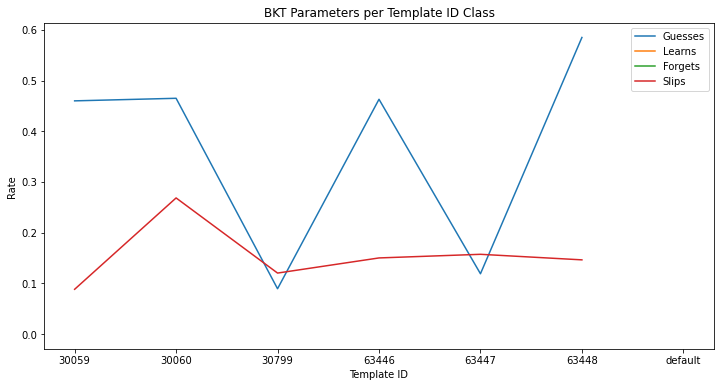

In [38]:
#Visualize learns, forgets, slips, guesses
params = model.params()
plt.figure(figsize = (12, 6))
plt.plot(params.loc[(skill, 'guesses')], label = 'Guesses')
plt.plot(params.loc[(skill, 'learns')], label = 'Learns')
plt.plot(params.loc[(skill, 'forgets')], label = 'Forgets')
plt.plot(params.loc[(skill, 'slips')], label = 'Slips')
plt.xlabel('Template ID')
plt.ylabel('Rate')
plt.title('BKT Parameters per Template ID Class')
plt.legend();